In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
df = pd.read_csv('./dataset/Apply_Rate_2019.csv').drop(['search_date_pacific', 'class_id'], axis=1)
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0
4,NaN,NaN,7.868900,0.008065,0.008772,0.0,7.0,0


In [2]:
df.isnull().sum()

title_proximity_tfidf          252571
description_proximity_tfidf    252571
main_query_tfidf                    0
query_jl_score                      0
query_title_score                   0
city_match                     256555
job_age_days                        0
apply                               0
dtype: int64

In [3]:
# start fking preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# drop duplicate
df.drop_duplicates(inplace=True)  # (len(df)=1112618, len(df[df['apply']==1])=99595), imbalanced

# fill missing values by MICE instead of mean
#df.fillna(df.mean(), inplace=True)
x_columns = df.columns
df = df.copy()
df = IterativeImputer().fit_transform(df)
df = pd.DataFrame(df, columns=x_columns)

df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply
count,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06
mean,5.466174e+00,9.854796e-02,1.878621e+00,1.713955e-02,3.617481e-02,5.478801e-01,1.053496e+01,9.061057e-02
std,9.435584e+00,2.601199e-01,2.255461e+00,1.247846e-02,4.943090e-02,4.393890e-01,1.785121e+01,2.870546e-01
min,-2.420884e+00,-7.675544e-02,0.000000e+00,1.000000e-06,9.998021e-07,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.041667e-02,1.228964e-02,0.000000e+00,2.000000e+00,0.000000e+00
50%,0.000000e+00,2.787808e-02,7.994508e-01,1.562500e-02,2.042031e-02,5.659572e-01,6.000000e+00,0.000000e+00
75%,1.039266e+01,9.635510e-02,3.576873e+00,2.070356e-02,3.826712e-02,1.000000e+00,1.500000e+01,0.000000e+00
max,9.351672e+01,7.301161e+00,1.774189e+01,2.556893e-01,1.294088e+00,1.000491e+00,1.340000e+03,1.000000e+00


In [4]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

train_x, test_x = train_test_split(df, test_size=0.2, random_state=4211)
train_y = train_x.pop('apply')
test_y = test_x.pop('apply')

# Normalisation using the sklearn StandardScaler. Set the mean to 0 and sd to 1.
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)  # fit training set only
test_x = scaler.transform(test_x)

x_columns = df.drop('apply',axis=1).columns
train_x = pd.DataFrame(train_x, columns=x_columns)
test_x = pd.DataFrame(test_x, columns=x_columns)

# undersampling to reduce imbalance
train_x, train_y = RandomUnderSampler(random_state=0).fit_resample(train_x, train_y)

train_x.head()

Using TensorFlow backend.


,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days
0,-0.579328,0.255671,-0.833158,-0.089076,-0.413537,-1.246978,-0.368326
1,-0.579328,0.326221,-0.833158,-0.064680,-0.334935,-1.246978,-0.593944
2,0.536029,0.994814,0.333678,-0.284022,-0.322382,-1.246978,-0.368326
3,-0.579328,-0.221307,2.112439,1.459150,-0.011471,-1.246978,0.646956
4,-0.579328,-0.378928,-0.833158,0.810768,-0.306908,-1.246978,0.477742


In [6]:
def report(clf):
    pred_y = clf.predict(test_x)

    print(classification_report(test_y, pred_y))
    disp = plot_confusion_matrix(clf, test_x, test_y)
    disp.figure_.suptitle("Confusion Matrix")

In [8]:
clf = LinearSVC(max_iter=3000) # default max_iter=1000

start = time.time()
clf.fit(train_x, train_y)
print(time.time()-start)

83.68337440490723


C:\Users\alanh\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

         0.0       0.92      0.68      0.78    197064
         1.0       0.12      0.43      0.18     19701

    accuracy                           0.65    216765
   macro avg       0.52      0.55      0.48    216765
weighted avg       0.85      0.65      0.73    216765



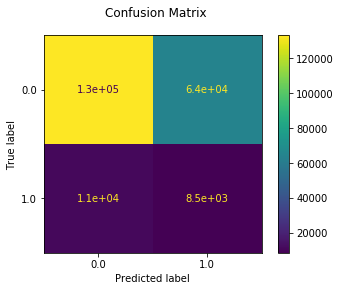

In [9]:
report(clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.2min finished
C:\Users\alanh\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.92      0.68      0.78    197064
           1       0.12      0.42      0.18     19701

    accuracy                           0.66    216765
   macro avg       0.52      0.55      0.48    216765
weighted avg       0.85      0.66      0.73    216765



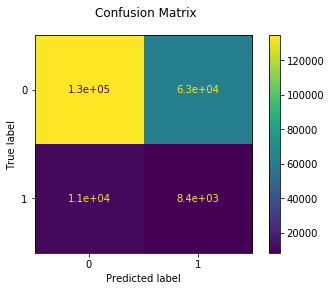

In [6]:
from sklearn.model_selection import GridSearchCV  # this thing cpu intensive.
tuned_parameters = {'C':np.arange(0.01,100,20)}

clf = GridSearchCV(LinearSVC(), tuned_parameters, n_jobs=-1, verbose=1)
clf.fit(train_x, train_y)
report(clf)  # no much difference

In [7]:
clf.estimator

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
clf = SVC()  # so fking slow even after normalisation, run for hrs still no output so I terminated this. 
            # Probably data size is too large for this, because it takes quadratic time to run (found from web).

start = time.time()
clf.fit(train_x, train_y)
print(time.time()-start)

report(clf)